In [4]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [3]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")

In [5]:
# Read the data
df = pd.read_excel("PSP_Jan_Feb_2019.xlsx")

In [6]:
print("Dataset Info:")
print(df.info())
print("\nFirst few rows:")
print(df.head())
print("\nBasic statistics:")
print(df.describe())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50410 entries, 0 to 50409
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  50410 non-null  int64         
 1   tmsp        50410 non-null  datetime64[ns]
 2   country     50410 non-null  object        
 3   amount      50410 non-null  int64         
 4   success     50410 non-null  int64         
 5   PSP         50410 non-null  object        
 6   3D_secured  50410 non-null  int64         
 7   card        50410 non-null  object        
dtypes: datetime64[ns](1), int64(4), object(3)
memory usage: 3.1+ MB
None

First few rows:
   Unnamed: 0                tmsp  country  amount  success         PSP  \
0           0 2019-01-01 00:01:11  Germany      89        0     UK_Card   
1           1 2019-01-01 00:01:17  Germany      89        1     UK_Card   
2           2 2019-01-01 00:02:49  Germany     238        0     UK_Card   
3      

In [7]:
# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Check for unique values in key columns
print("\nUnique Values Per Column:")
for column in df.columns:
    print(f"{column}: {df[column].nunique()} unique values")


Missing Values:
Unnamed: 0    0
tmsp          0
country       0
amount        0
success       0
PSP           0
3D_secured    0
card          0
dtype: int64

Unique Values Per Column:
Unnamed: 0: 50410 unique values
tmsp: 50121 unique values
country: 3 unique values
amount: 517 unique values
success: 2 unique values
PSP: 4 unique values
3D_secured: 2 unique values
card: 3 unique values


In [8]:
# Data Preprocessing
# Step 1: Remove the 'Unnamed: 0' column as it is not needed
df = df.drop(columns=['Unnamed: 0'])

# Step 2: Convert 'tmsp' to datetime if it’s not already
df['tmsp'] = pd.to_datetime(df['tmsp'])

# Step 3: Identify multiple attempts for the same purchase
# First, sort the data by country, amount, and timestamp
df = df.sort_values(by=['country', 'amount', 'tmsp'])

# Group transactions based on 'country' and 'amount' and identify attempts within a minute
df['attempt_group'] = df.groupby(['country', 'amount'])['tmsp'].diff().lt('1min').cumsum()

# Optional: Check for grouped attempts
print("\nGrouped Attempts (First 5 rows):")
print(df[['tmsp', 'country', 'amount', 'attempt_group']].head())

# Step 4: Remove the 'tmsp' duplicates for grouped attempts, keeping only the first attempt (for each group)
df = df.drop_duplicates(subset=['attempt_group', 'country', 'amount'], keep='first')

# Verify the changes
print("\nData After Removing Duplicates (First 5 rows):")
print(df.head())



Grouped Attempts (First 5 rows):
                     tmsp  country  amount  attempt_group
9238  2019-01-10 03:49:12  Austria       6              0
9239  2019-01-10 03:49:37  Austria       6              1
22742 2019-01-27 14:01:11  Austria       6              1
33737 2019-02-08 05:02:33  Austria       6              1
33738 2019-02-08 05:02:37  Austria       6              2

Data After Removing Duplicates (First 5 rows):
                     tmsp  country  amount  success         PSP  3D_secured  \
9238  2019-01-10 03:49:12  Austria       6        0   Moneycard           0   
9239  2019-01-10 03:49:37  Austria       6        0  Simplecard           0   
33738 2019-02-08 05:02:37  Austria       6        0     UK_Card           0   
33739 2019-02-08 05:02:39  Austria       6        0  Simplecard           0   
21179 2019-01-25 04:18:26  Austria       7        0   Moneycard           0   

         card  attempt_group  
9238   Diners              0  
9239   Diners              1  
33

In [9]:
# Time-based features
df['hour_of_day'] = df['tmsp'].dt.hour
df['day_of_week'] = df['tmsp'].dt.dayofweek

# Identify retry transactions (same country, amount, within 1 minute)
df['is_retry'] = df.groupby(['country', 'amount'])['tmsp'].diff().lt('1min').astype(int)

# Log transformation of the amount
df['log_amount'] = np.log1p(df['amount'])

# 3D Secured feature
df['is_3d_secured'] = df['3D_secured']

# Display the first few rows to check the new features
print(df[['tmsp', 'country', 'amount', 'is_retry', 'log_amount', 'is_3d_secured']].head())


                     tmsp  country  amount  is_retry  log_amount  \
9238  2019-01-10 03:49:12  Austria       6         0    1.945910   
9239  2019-01-10 03:49:37  Austria       6         1    1.945910   
33738 2019-02-08 05:02:37  Austria       6         0    1.945910   
33739 2019-02-08 05:02:39  Austria       6         1    1.945910   
21179 2019-01-25 04:18:26  Austria       7         0    2.079442   

       is_3d_secured  
9238               0  
9239               0  
33738              0  
33739              0  
21179              0  


In [10]:
# Total attempts for the same purchase
df['total_attempts'] = df.groupby(['country', 'amount'])['attempt_group'].transform('max') + 1

# First attempt flag (1 if first attempt, 0 otherwise)
df['first_attempt'] = (df['attempt_group'] == 0).astype(int)

# Time-related features
df['hour'] = df['tmsp'].dt.hour
df['day_of_week'] = df['tmsp'].dt.dayofweek

# Time since last attempt (in minutes)
df['time_since_last_attempt'] = df.groupby(['country', 'amount'])['tmsp'].diff().dt.total_seconds() / 60
df['time_since_last_attempt'] = df['time_since_last_attempt'].fillna(0)  # Fill NaN values for the first attempts

# One-hot encoding for PSP, 3D Secured, and Card Type
df = pd.get_dummies(df, columns=['PSP', '3D_secured', 'card'], drop_first=True)

# Label encoding for 'country' column (if it's categorical)
label_encoder = LabelEncoder()
df['country'] = label_encoder.fit_transform(df['country'])

# Preview the data after feature engineering
df.head()


,tmsp,country,amount,success,attempt_group,hour_of_day,day_of_week,is_retry,log_amount,is_3d_secured,total_attempts,first_attempt,hour,time_since_last_attempt,PSP_Moneycard,PSP_Simplecard,PSP_UK_Card,3D_secured_1,card_Master,card_Visa
9238,2019-01-10 03:49:12,0,6,0,0,3,3,0,1.945910,0,4,1,3,0.000000,True,False,False,False,False,False
9239,2019-01-10 03:49:37,0,6,0,1,3,3,1,1.945910,0,4,0,3,0.416667,False,True,False,False,False,False
33738,2019-02-08 05:02:37,0,6,0,2,5,4,0,1.945910,0,4,0,5,41833.000000,False,False,True,False,False,False
33739,2019-02-08 05:02:39,0,6,0,3,5,4,1,1.945910,0,4,0,5,0.033333,False,True,False,False,False,False
21179,2019-01-25 04:18:26,0,7,0,3,4,4,0,2.079442,0,8,0,4,0.000000,True,False,False,False,True,False


In [11]:
# Add total attempts for the same purchase
df['total_attempts'] = df.groupby(['country', 'amount'])['attempt_group'].transform('max') + 1

# Add first attempt flag
df['first_attempt'] = (df['attempt_group'] == 0).astype(int)

# Add time since last attempt 
df['time_since_last_attempt'] = df.groupby(['country', 'amount'])['tmsp'].diff().dt.total_seconds() / 60
df['time_since_last_attempt'] = df['time_since_last_attempt'].fillna(0)  # Fill NaN for the first attempts

# Verify the newly added features
print(df.head())


                     tmsp  country  amount  success  attempt_group  \
9238  2019-01-10 03:49:12        0       6        0              0   
9239  2019-01-10 03:49:37        0       6        0              1   
33738 2019-02-08 05:02:37        0       6        0              2   
33739 2019-02-08 05:02:39        0       6        0              3   
21179 2019-01-25 04:18:26        0       7        0              3   

       hour_of_day  day_of_week  is_retry  log_amount  is_3d_secured  \
9238             3            3         0    1.945910              0   
9239             3            3         1    1.945910              0   
33738            5            4         0    1.945910              0   
33739            5            4         1    1.945910              0   
21179            4            4         0    2.079442              0   

       total_attempts  first_attempt  hour  time_since_last_attempt  \
9238                4              1     3                 0.000000   
9239

Logistic Regression Metrics:
Confusion Matrix:
[[2248 1595]
 [ 384  616]]
AUC ROC: 0.6283406193078325
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.58      0.69      3843
           1       0.28      0.62      0.38      1000

    accuracy                           0.59      4843
   macro avg       0.57      0.60      0.54      4843
weighted avg       0.74      0.59      0.63      4843



Random Forest Metrics:
Confusion Matrix:
[[3279  564]
 [ 789  211]]
AUC ROC: 0.6176337496747333
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.85      0.83      3843
           1       0.27      0.21      0.24      1000

    accuracy                           0.72      4843
   macro avg       0.54      0.53      0.53      4843
weighted avg       0.70      0.72      0.71      4843



XGBoost Metrics:
Confusion Matrix:
[[3661  182]
 [ 912   88]]
AUC ROC: 0.6224247983346345
Classifi

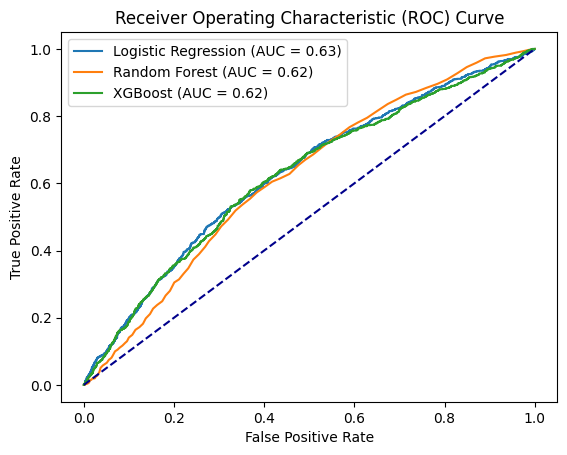

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
)
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Step 1: Prepare the data
target = 'success'
features = [
    'amount', 'is_retry', 'log_amount', 'is_3d_secured',
    'PSP_Moneycard', 'PSP_Simplecard', 'PSP_UK_Card',
    'card_Master', 'card_Visa', 'attempt_group',
    'hour_of_day', 'day_of_week'
]

X = df[features]
y = df[target]

# Step 2: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Scale and resample the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train_scaled, y_train)

# Step 4: Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=len(y_train_resampled[y_train_resampled == 0]) / len(y_train_resampled[y_train_resampled == 1]), random_state=42)
}

# Step 5: Train and evaluate models
def train_and_evaluate(models, X_train, X_test, y_train, y_test):
    model_scores = {}
    for name, model in models.items():
        # Train the model
        model.fit(X_train, y_train)
        
        # Predict labels and probabilities
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
        
        # Calculate metrics
        conf_matrix = confusion_matrix(y_test, y_pred)
        auc_roc = roc_auc_score(y_test, y_proba) if y_proba is not None else "N/A"
        
        # Store metrics
        model_scores[name] = {
            'Confusion Matrix': conf_matrix,
            'AUC ROC': auc_roc,
            'Classification Report': classification_report(y_test, y_pred, zero_division=0)
        }
        
        # Print metrics
        print(f"{name} Metrics:")
        print(f"Confusion Matrix:\n{conf_matrix}")
        print(f"AUC ROC: {auc_roc}")
        print(f"Classification Report:\n{classification_report(y_test, y_pred, zero_division=0)}")
        print("\n")
        
        # Plot ROC Curve if probabilities are available
        if y_proba is not None:
            fpr, tpr, _ = roc_curve(y_test, y_proba)
            plt.plot(fpr, tpr, linestyle='-', label=f'{name} (AUC = {auc_roc:.2f})')
    
    # Finalize and show the ROC Curve plot
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

    return model_scores

# Step 6: Train and evaluate models
model_scores = train_and_evaluate(models, X_train_resampled, X_test_scaled, y_train_resampled, y_test)


In [24]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import numpy as np

# Step 1: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 3: Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Step 4: Hyperparameter tuning using GridSearchCV
logreg = LogisticRegression(max_iter=1000, random_state=42)
param_grid = {
    'C': [0.1, 1, 10],
    'class_weight': ['balanced', None]
}
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train_resampled, y_train_resampled)

# Step 5: Get the best model
best_logreg = grid_search.best_estimator_
print("Best Hyperparameters:", grid_search.best_params_)

Best Hyperparameters: {'C': 10, 'class_weight': 'balanced'}


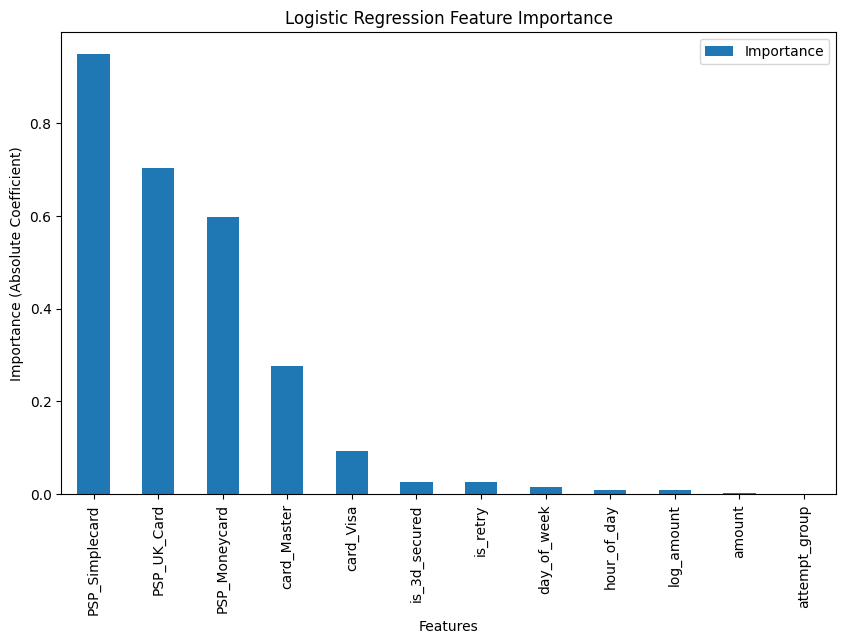

In [23]:
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

# Assuming you have already trained the logistic regression model as `logreg`
logreg_importance = abs(logreg.coef_[0])  # Taking absolute values for importance
logreg_features = X_train.columns  # Assuming X_train is your DataFrame containing feature names

# Create a DataFrame to hold the feature names and their importance
logreg_feature_importance = pd.DataFrame(logreg_importance, index=logreg_features, columns=["Importance"])

# Sort features by importance (descending)
logreg_feature_importance = logreg_feature_importance.sort_values(by="Importance", ascending=False)

# Plot the top features based on logistic regression coefficients
logreg_feature_importance.plot(kind='bar', title='Logistic Regression Feature Importance', figsize=(10, 6))
plt.ylabel('Importance (Absolute Coefficient)')
plt.xlabel('Features')
plt.show()
